Task 1: Implement your own LeNet-5 for MNIST dataset.

Change all architecture choices
Number of filters
Size of filters
Activation (use ReLU)
Keep the pooling (size and stride) and the padding
Use dropout (dropout rate = 0.5)
Use L2 regularization for dense layers (except last one)
 

Training Settings:
Normalize the data
Split the data into 70% training set and 30% testing set.
Adam optimizer with 2e-4 learning rate.
Batch size = 32
Number of training epochs = 50
Obtain the training and testing accuracy.


In [ ]:
Make sure to change runtime to GPU. Need that and below code chunk to run this bad girl.

In [ ]:
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15101 MiB



Load helpful libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

Load the data. Concatenate and redo test/train split to our liking.


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

#then split using train_test_split
#from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=(0.3))

11490434/11490434 [==============================] - 0s 0us/step


Convert to One-Hot Encoding please and thank you.


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10) 
y_test = tf.keras.utils.to_categorical(y_test, 10)

Inspect image pixel value

In [ ]:
x_train[0].min(), x_train[0].max()

(0, 255)

Normalize the data

In [ ]:
x_train = x_train/255
x_test = x_test/255

x_train[0].min(), x_train[0].max()

(0.0, 1.0)

Shape check. Satisfied to have the correct test/train split! X is 28 by 28 for all the pixels, and y is 10 because it can take values 0-9.

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((49000, 28, 28), (21000, 28, 28), (49000, 10), (21000, 10))

Not reshaping. Don't need to flatten for CNN.
Adding in the grayscale channel with last 1.

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


x_train.shape, x_test.shape, y_train.shape, y_test.shape

((49000, 28, 28, 1), (21000, 28, 28, 1), (49000, 10), (21000, 10))

Define the model:
Change number of filters, Size of filters Activation (use ReLU) Keep the pooling (size and stride) and the padding Use dropout (dropout rate = 0.5) Use L2 regularization for dense layers (except last one). 

In [ ]:
def net(loss, optimizer):
    net = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='ReLU',
                               padding='same', input_shape=(28,28,1)),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=48, kernel_size=3,
                               activation='ReLU'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='ReLU', kernel_regularizer='L2'),
        tf.keras.layers.Dense(84, activation='ReLU', kernel_regularizer='L2'),
        tf.keras.layers.Dense(10, activation='softmax')])
    
    net.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return net

Define learning rate, epochs, batach size, loss, and optimizer

In [ ]:
lr = 0.0002
num_epochs = 50
batch_size= 32

loss= tf.keras.losses.CategoricalCrossentropy()
optimizer=tf.optimizers.Adam(learning_rate=lr)

Inspect the model to make sure it's what we expect, and it is

In [ ]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net(loss, optimizer).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Conv2D output shape: 	 (1, 28, 28, 24)
AveragePooling2D output shape: 	 (1, 14, 14, 24)
Conv2D output shape: 	 (1, 12, 12, 48)
Dropout output shape: 	 (1, 12, 12, 48)
AveragePooling2D output shape: 	 (1, 6, 6, 48)
Flatten output shape: 	 (1, 1728)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


Checking number of parameters. No training happening in pooling, dropout, or flattening layers so no trainable parameters there.

In [ ]:
lenet = net(loss, optimizer)

lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 24)        240       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 24)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 48)        10416     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 48)        0         
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 48)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 1728)             

I suppose the visual of the layers would be helpful

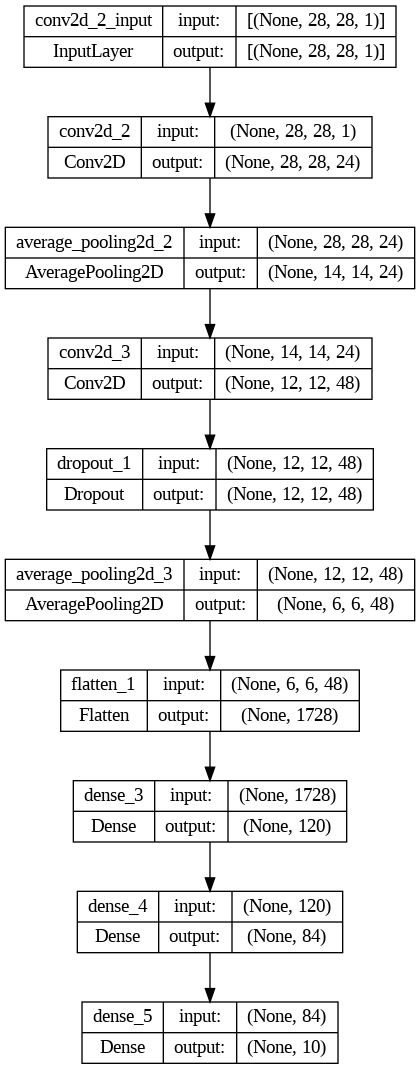

In [ ]:
tf.keras.utils.plot_model(lenet, show_shapes=True)

So...this is when we train the model.

In [ ]:
history = lenet.fit(x_train, y_train, 
            epochs=50,
            batch_size=batch_size,
            validation_data=(x_test, y_test))

Epoch 1/50
1532/1532 [==============================] - 10s 6ms/step - loss: 0.0976 - accuracy: 0.9827 - val_loss: 0.0988 - val_accuracy: 0.9826
Epoch 2/50
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0976 - accuracy: 0.9830 - val_loss: 0.0968 - val_accuracy: 0.9844
Epoch 3/50
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0955 - accuracy: 0.9830 - val_loss: 0.0915 - val_accuracy: 0.9860
Epoch 4/50
1532/1532 [==============================] - 10s 6ms/step - loss: 0.0955 - accuracy: 0.9838 - val_loss: 0.0925 - val_accuracy: 0.9849
Epoch 5/50
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0967 - accuracy: 0.9829 - val_loss: 0.0961 - val_accuracy: 0.9837
Epoch 6/50
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0933 - accuracy: 0.9838 - val_loss: 0.0948 - val_accuracy: 0.9851
Epoch 7/50
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0943 - accuracy: 0.9837 - val_loss: 0.0973 - val_accurac

From above we see training accuracy of 0.9859 and test accuracy of 0.9863. That is an A+ model.

Plotting train and test accuracy rates, and they look good. hist_ is a dataframe=history.history Oh I see it in the code below now.

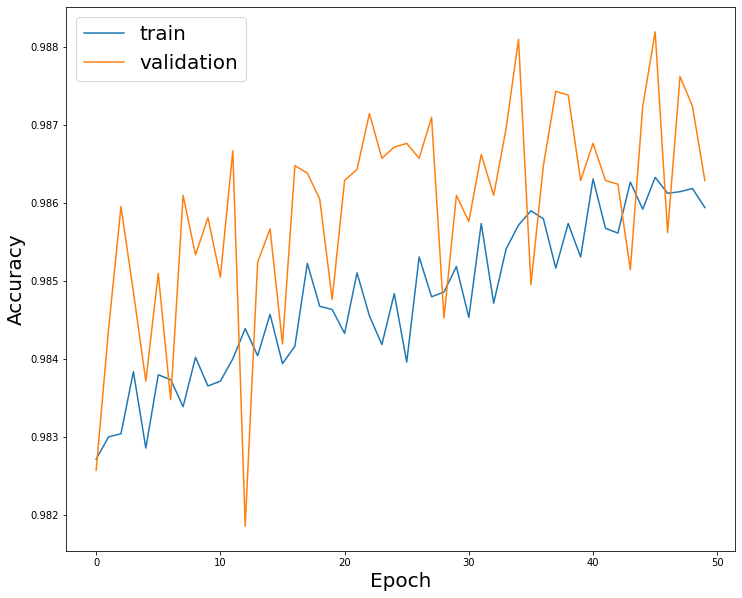

In [ ]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

Printing out test accuracy because we can.

In [ ]:
score = lenet.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09368486702442169
Test accuracy: 0.9858095049858093
